In [1]:
import uproot, ROOT, glob, os, random
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
from sklearn.metrics import roc_curve, roc_auc_score, auc
from tqdm import tqdm
import pandas as pd
from xgboost import XGBClassifier
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split

# Set up plot defaults
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 12.0,8.0  # Roughly 11 cm wde by 8 cm high
mpl.rcParams['font.size'] = 16.0 # Use 14 point font
sns.set(style="whitegrid")

path = '/eos/user/j/jlai/ditau/'

branches = ['ditau_pt', 'n_subjets', 'IsTruthHadronic', 'n_tracks_lead', 'n_tracks_subl',
 'R_max_lead', 'R_max_subl', 'R_tracks_subl', 'R_isotrack', 'd0_leadtrack_lead',
 'd0_leadtrack_subl', 'f_core_lead', 'f_core_subl', 'f_subjet_subl', 'f_subjets',
 'f_isotracks', 'm_core_lead', 'm_core_subl', 'm_tracks_lead', 'm_tracks_subl',
 'n_track']

training_vars = [
    "f_core_lead", "f_core_subl", "f_subjet_subl", "f_subjets", "f_isotracks",
    "R_max_lead", "R_max_subl", "R_isotrack", "R_tracks_subl", "m_core_lead",
    "m_core_subl", "m_tracks_lead", "m_tracks_subl", "d0_leadtrack_lead",
    "d0_leadtrack_subl", "n_track", "n_tracks_lead"
]

Welcome to JupyROOT 6.30/04


## Read data (h5 -> panda)

In [26]:
%%time

signal = pd.read_csv('combined_signal_inc_3.csv')
bkg = pd.read_csv('combined_bkg_inc_3.csv')

signal['label'] = 1
bkg['label'] = 0
signal['weight'] = signal['event_weight'] * signal['pT_weight']
bkg['weight'] = bkg['event_weight'] * bkg['pT_weight']

df = pd.concat((bkg, signal))
df = df[4:] # get rid of jz0 and jz1
df = df[df.f_core_subl != -999]
df.describe()

CPU times: user 32.3 s, sys: 7.68 s, total: 39.9 s
Wall time: 39.7 s


,event_id,ditau_pt,IsTruthHadronic,f_core_lead,f_core_subl,f_subjet_subl,f_subjets,f_isotracks,R_max_lead,R_max_subl,...,n_tracks_subl,n_subjets,event_weight,bdt_score,bdt_score_new,eta,average_mu,pT_weight,label,weight
count,7.022737e+06,7.022737e+06,7.022737e+06,7.022737e+06,7.022737e+06,7.022737e+06,7.022737e+06,7.022737e+06,7.022737e+06,7.022737e+06,...,7.022737e+06,7.022737e+06,7.022737e+06,7.022737e+06,7.022737e+06,7.022737e+06,7.022737e+06,7.022737e+06,7.022737e+06,7.022737e+06
mean,7.745517e+07,4.855167e+05,6.895014e-01,8.839027e-01,6.901608e-01,1.727639e-01,8.817098e-01,9.255464e-03,4.384086e-02,5.969501e-02,...,1.552625e+00,2.264665e+00,7.491312e-05,6.637519e-01,6.594455e-01,1.571932e-03,4.239657e+01,1.077045e+09,6.895004e-01,1.109615e-05
std,1.290227e+08,1.905369e+05,4.626978e-01,9.268683e-02,2.583384e-01,1.334849e-01,9.478742e-02,4.044705e-02,5.775711e-02,6.071469e-02,...,8.943464e-01,6.560886e-01,9.953396e-04,1.328381e-01,4.272000e-01,9.853873e-01,1.121378e+01,3.056278e+09,4.626982e-01,5.202410e-05
min,1.000000e+00,2.000000e+05,0.000000e+00,1.246108e-03,2.094379e-04,1.801535e-03,3.916248e-02,0.000000e+00,7.248037e-06,1.008136e-05,...,1.000000e+00,2.000000e+00,2.546348e-18,2.524264e-01,1.220086e-03,-2.499992e+00,5.000000e-01,4.301412e-03,0.000000e+00,2.139712e-18
25%,7.247488e+06,3.327258e+05,0.000000e+00,8.506744e-01,5.242175e-01,4.937525e-02,8.444495e-01,0.000000e+00,7.686741e-03,1.358677e-02,...,1.000000e+00,2.000000e+00,6.208920e-15,5.648812e-01,6.512229e-02,-7.067792e-01,3.350000e+01,1.810387e+00,0.000000e+00,1.644756e-06
50%,1.446259e+07,4.431366e+05,1.000000e+00,9.066620e-01,7.878287e-01,1.386378e-01,9.106000e-01,4.852759e-03,1.498540e-02,2.875121e-02,...,1.000000e+00,2.000000e+00,4.253118e-14,7.220567e-01,9.597747e-01,1.215448e-03,4.250000e+01,4.762986e+07,1.000000e+00,4.885583e-06
75%,7.829976e+07,6.059209e+05,1.000000e+00,9.459768e-01,8.966472e-01,2.782594e-01,9.477134e-01,1.205322e-02,5.116755e-02,1.006651e-01,...,3.000000e+00,2.000000e+00,6.135377e-06,7.621443e-01,9.935072e-01,7.099840e-01,5.050000e+01,4.837491e+08,1.000000e+00,1.196750e-05
max,4.930031e+08,9.999998e+05,1.000000e+00,9.995749e-01,1.000000e+00,5.376042e-01,1.097981e+00,3.583736e+01,2.000000e-01,2.000000e-01,...,3.000000e+00,1.600000e+01,1.443402e+00,8.306370e-01,9.975621e-01,2.499999e+00,9.050000e+01,2.181098e+10,1.000000e+00,6.991486e-02


### separate data by 1p1p, 1p3p, 3p3p

In [17]:
df_1p1p = df[(df['n_tracks_lead'] == 1) & (df['n_tracks_subl'] == 1)]
df_3p3p = df[(df['n_tracks_lead'] == 3) & (df['n_tracks_subl'] == 3)]
df_1p3p = df[
    ((df['n_tracks_lead'] == 1) & (df['n_tracks_subl'] == 3)) |
    ((df['n_tracks_lead'] == 3) & (df['n_tracks_subl'] == 1))
]

len(df_1p1p), len(df_3p3p), len(df_1p3p)

(3010333, 942445, 3069959)

/tmp/ipykernel_1358/3912952945.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['eventID_mod'] = df['event_id'] % 5
/tmp/ipykernel_1358/3912952945.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weight'] = df['event_weight'] * df['pT_weight']


train bkg: 489859, train signal: 264181, test bkg: 122617, test signal: 65788
Fitting 3 folds for each of 30 candidates, totalling 90 fits


/tmp/ipykernel_1358/3912952945.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data.rename(columns=feature_mapping, inplace=True)
/tmp/ipykernel_1358/3912952945.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_data.rename(columns=feature_mapping, inplace=True)
/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x

[0]	validation_0-logloss:0.62861
[1]	validation_0-logloss:0.59871
[2]	validation_0-logloss:0.57162
[3]	validation_0-logloss:0.54713
[4]	validation_0-logloss:0.54782
[5]	validation_0-logloss:0.54844
[6]	validation_0-logloss:0.54899
[7]	validation_0-logloss:0.54948
[8]	validation_0-logloss:0.54990
[9]	validation_0-logloss:0.55028
[10]	validation_0-logloss:0.55061
[11]	validation_0-logloss:0.55090
[12]	validation_0-logloss:0.55115
Best parameters found:  {'n_estimators': 450, 'max_depth': 3, 'learning_rate': 0.2}
Testing accuracy after early stopping:  0.749533583874036


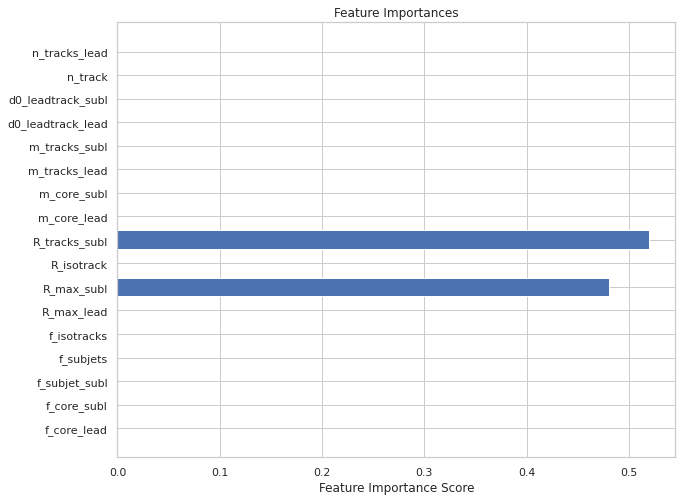

In [31]:
def BDT(df):
    training_vars = ["f_core_lead",
                    "f_core_subl",
                    "f_subjet_subl",
                    "f_subjets",
                    "f_isotracks",
                    "R_max_lead",
                    "R_max_subl",
                    "R_isotrack",
                    "R_tracks_subl",
                    "m_core_lead",
                    "m_core_subl",
                    "m_tracks_lead",
                    "m_tracks_subl",
                    "d0_leadtrack_lead",
                    "d0_leadtrack_subl",
                    "n_track",
                    "n_tracks_lead"]


    # Scrambling
    # Calculate the modulo of each eventID with 5
    df['eventID_mod'] = df['event_id'] % 5

    df['weight'] = df['event_weight'] * df['pT_weight']

    log_vars = ["f_isotracks", "m_core_lead", "m_core_subl", "m_tracks_lead", "m_tracks_subl"]
    abs_log_var = ["d0_leadtrack_lead", "d0_leadtrack_subl"]

    train_df = df[df['eventID_mod'] < 4] # 80%
    test_df = df[df['eventID_mod'] == 4] # 20%
    print(f'train bkg: {len(train_df[train_df.label==0])}, train signal: {len(train_df[train_df.label==1])}, test bkg: {len(test_df[test_df.label==0])}, test signal: {len(test_df[test_df.label==1])}')

    train_df = train_df.drop(columns='eventID_mod')
    test_df = test_df.drop(columns='eventID_mod')

    # Training & Testing sets
    training_data, testing_data, training_labels, testing_labels, training_weights, testing_weights = \
    train_df[training_vars], test_df[training_vars], train_df['label'], test_df['label'], train_df['weight'], test_df['weight']

    #Change column names to integers if needed (for ML models that expect numerical feature names)
    feature_mapping = {feature: i for i, feature in enumerate(training_data.columns)}
    training_data.rename(columns=feature_mapping, inplace=True)
    feature_mapping = {feature: i for i, feature in enumerate(testing_data.columns)}
    testing_data.rename(columns=feature_mapping, inplace=True)

    # Define the classifier
    bdt = XGBClassifier(random_state=0, verbosity=1)

    # Define the parameter distribution
    param_dist = {
        'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500],
        'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.3],
        'max_depth': [2, 3, 4, 5, 6]
    }

    # Define the search with RandomizedSearchCV
    random_search = RandomizedSearchCV(estimator=bdt, param_distributions=param_dist, n_iter=30, scoring='accuracy', cv=3, verbose=2, n_jobs=-1)

    # Perform the search
    # Note: We don't use the testing set here; it's for final evaluation
    random_search.fit(training_data, training_labels, sample_weight=training_weights)

    # Best estimator found by RandomizedSearchCV
    best_estimator = random_search.best_estimator_

    # Manually apply early stopping using a portion of the training set as a validation set
    # Note: XGBoost handles validation sets for early stopping, but we use training and testing sets as provided
    eval_set = [(testing_data, testing_labels)]
    best_estimator.fit(training_data, training_labels, sample_weight=training_weights, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=True)

    # Predictions and final evaluation on the testing set
    predictions = best_estimator.predict(testing_data)
    accuracy = accuracy_score(testing_labels, predictions, sample_weight=testing_weights)

    # Output the results
    print("Best parameters found: ", random_search.best_params_)
    print("Testing accuracy after early stopping: ", accuracy)

    # Predict probabilities for the testing data
    probs = best_estimator.predict_proba(testing_data)
    probs = probs[:, 1]
    
    # Feature Importance
    importance = best_estimator.feature_importances_
    # Re-map the feature importance scores to the original feature names
    feature_importances = {training_vars[i]: score for i, score in enumerate(importance)}

    # Plot feature importance
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(feature_importances)), list(feature_importances.values()), align='center')
    plt.yticks(range(len(feature_importances)), list(feature_importances.keys()))
    plt.xlabel('Feature Importance Score')
    plt.title('Feature Importances')
    plt.show()

    fpr, tpr, thresholds = roc_curve(testing_labels, probs, sample_weight=testing_weights)
    auc = roc_auc_score(testing_labels, probs, sample_weight=testing_weights)


    return fpr, tpr, thresholds, auc

fpr2, tpr2, thresholds2, auc2 = BDT(df_3p3p)

/tmp/ipykernel_1358/3592393373.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['eventID_mod'] = df['event_id'] % 5
/tmp/ipykernel_1358/3592393373.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weight'] = df['event_weight'] * df['pT_weight']


train bkg: 293741, train signal: 2114730, test bkg: 73962, test signal: 527900


/tmp/ipykernel_1358/3592393373.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data.rename(columns=feature_mapping, inplace=True)
/tmp/ipykernel_1358/3592393373.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_data.rename(columns=feature_mapping, inplace=True)


Fitting 3 folds for each of 30 candidates, totalling 90 fits


/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.35299
[1]	validation_0-logloss:0.30877
[2]	validation_0-logloss:0.27940
[3]	validation_0-logloss:0.25266
[4]	validation_0-logloss:0.23204
[5]	validation_0-logloss:0.21836
[6]	validation_0-logloss:0.20559
[7]	validation_0-logloss:0.19367
[8]	validation_0-logloss:0.18212
[9]	validation_0-logloss:0.17282
[10]	validation_0-logloss:0.16631
[11]	validation_0-logloss:0.16039
[12]	validation_0-logloss:0.15471
[13]	validation_0-logloss:0.14911
[14]	validation_0-logloss:0.14915
[15]	validation_0-logloss:0.14919
[16]	validation_0-logloss:0.14921
[17]	validation_0-logloss:0.14923
[18]	validation_0-logloss:0.14925
[19]	validation_0-logloss:0.14926
[20]	validation_0-logloss:0.14927
[21]	validation_0-logloss:0.14928
[22]	validation_0-logloss:0.14929
[23]	validation_0-logloss:0.14929
Best parameters found:  {'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.3}
Testing accuracy after early stopping:  0.9441825151095726


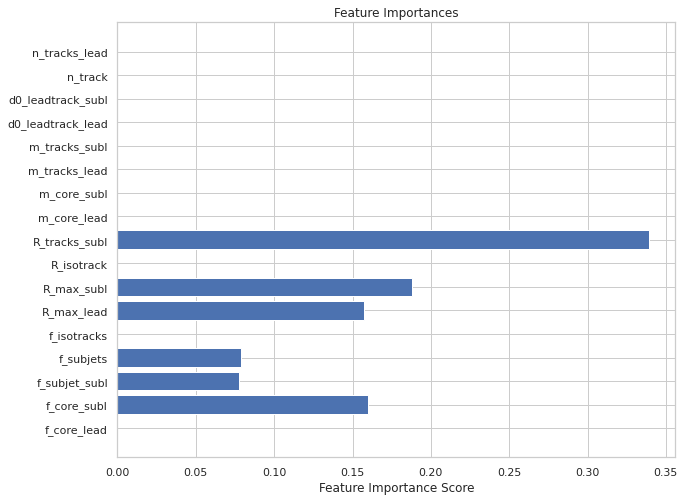

/tmp/ipykernel_1358/3592393373.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['eventID_mod'] = df['event_id'] % 5
/tmp/ipykernel_1358/3592393373.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weight'] = df['event_weight'] * df['pT_weight']


train bkg: 489859, train signal: 264181, test bkg: 122617, test signal: 65788
Fitting 3 folds for each of 30 candidates, totalling 90 fits


/tmp/ipykernel_1358/3592393373.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data.rename(columns=feature_mapping, inplace=True)
/tmp/ipykernel_1358/3592393373.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_data.rename(columns=feature_mapping, inplace=True)
/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x

[0]	validation_0-logloss:0.65343
[1]	validation_0-logloss:0.64510
[2]	validation_0-logloss:0.63694
[3]	validation_0-logloss:0.62905
[4]	validation_0-logloss:0.62131
[5]	validation_0-logloss:0.61381
[6]	validation_0-logloss:0.60645
[7]	validation_0-logloss:0.59930
[8]	validation_0-logloss:0.59228
[9]	validation_0-logloss:0.58544
[10]	validation_0-logloss:0.57876
[11]	validation_0-logloss:0.57230
[12]	validation_0-logloss:0.56595
[13]	validation_0-logloss:0.55976
[14]	validation_0-logloss:0.55376
[15]	validation_0-logloss:0.55393
[16]	validation_0-logloss:0.55409
[17]	validation_0-logloss:0.55424
[18]	validation_0-logloss:0.55440
[19]	validation_0-logloss:0.55454
[20]	validation_0-logloss:0.55469
[21]	validation_0-logloss:0.55483
[22]	validation_0-logloss:0.55496
[23]	validation_0-logloss:0.55509
[24]	validation_0-logloss:0.55522
Best parameters found:  {'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.05}
Testing accuracy after early stopping:  0.749533583874036


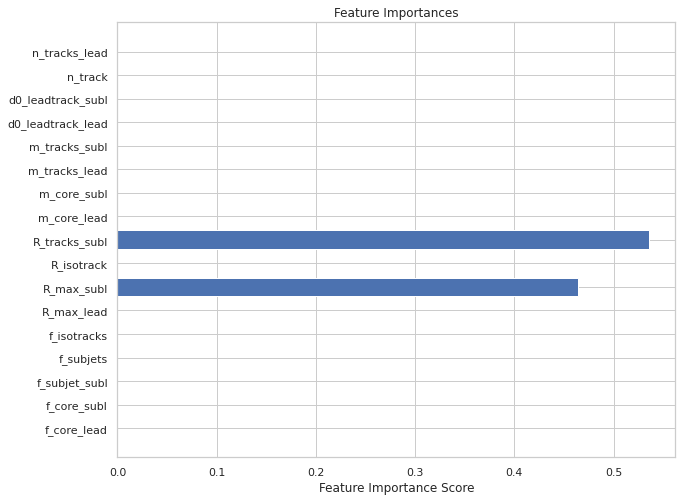

/tmp/ipykernel_1358/3592393373.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['eventID_mod'] = df['event_id'] % 5
/tmp/ipykernel_1358/3592393373.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weight'] = df['event_weight'] * df['pT_weight']


train bkg: 960356, train signal: 1495605, test bkg: 240022, test signal: 373976


/tmp/ipykernel_1358/3592393373.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data.rename(columns=feature_mapping, inplace=True)
/tmp/ipykernel_1358/3592393373.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_data.rename(columns=feature_mapping, inplace=True)


Fitting 3 folds for each of 30 candidates, totalling 90 fits


/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.63457
[1]	validation_0-logloss:0.55960
[2]	validation_0-logloss:0.50052
[3]	validation_0-logloss:0.45310
[4]	validation_0-logloss:0.41442
[5]	validation_0-logloss:0.38286
[6]	validation_0-logloss:0.35496
[7]	validation_0-logloss:0.33465
[8]	validation_0-logloss:0.31508
[9]	validation_0-logloss:0.29836
[10]	validation_0-logloss:0.28483
[11]	validation_0-logloss:0.27381
[12]	validation_0-logloss:0.26217
[13]	validation_0-logloss:0.25247
[14]	validation_0-logloss:0.24562
[15]	validation_0-logloss:0.23881
[16]	validation_0-logloss:0.23286
[17]	validation_0-logloss:0.22623
[18]	validation_0-logloss:0.22083
[19]	validation_0-logloss:0.21623
[20]	validation_0-logloss:0.21250
[21]	validation_0-logloss:0.20800
[22]	validation_0-logloss:0.20397
[23]	validation_0-logloss:0.20027
[24]	validation_0-logloss:0.19770
[25]	validation_0-logloss:0.19483
[26]	validation_0-logloss:0.19262
[27]	validation_0-logloss:0.19031
[28]	validation_0-logloss:0.18760
[29]	validation_0-loglos

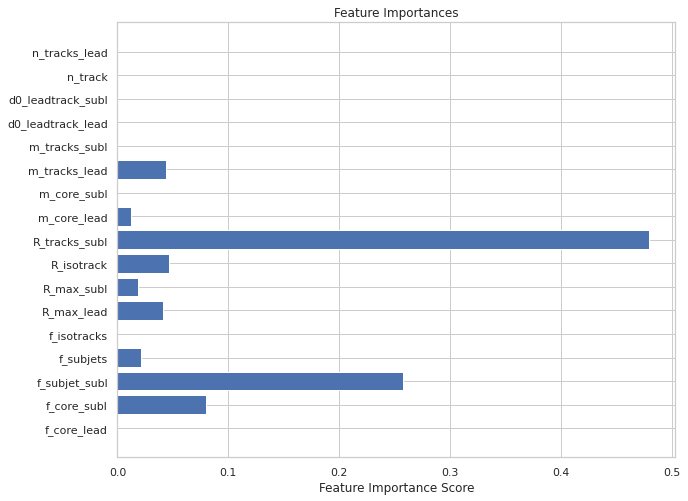

train bkg: 1743956, train signal: 3874516, test bkg: 436601, test signal: 967664


/tmp/ipykernel_1358/3592393373.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data.rename(columns=feature_mapping, inplace=True)
/tmp/ipykernel_1358/3592393373.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_data.rename(columns=feature_mapping, inplace=True)


Fitting 3 folds for each of 30 candidates, totalling 90 fits


/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.62407
[1]	validation_0-logloss:0.57422
[2]	validation_0-logloss:0.53153
[3]	validation_0-logloss:0.49477
[4]	validation_0-logloss:0.46257
[5]	validation_0-logloss:0.43448
[6]	validation_0-logloss:0.40919
[7]	validation_0-logloss:0.38751
[8]	validation_0-logloss:0.36782
[9]	validation_0-logloss:0.34978
[10]	validation_0-logloss:0.33320
[11]	validation_0-logloss:0.31889
[12]	validation_0-logloss:0.30606
[13]	validation_0-logloss:0.29397
[14]	validation_0-logloss:0.28281
[15]	validation_0-logloss:0.27349
[16]	validation_0-logloss:0.26511
[17]	validation_0-logloss:0.25624
[18]	validation_0-logloss:0.24876
[19]	validation_0-logloss:0.24163
[20]	validation_0-logloss:0.23446
[21]	validation_0-logloss:0.22860
[22]	validation_0-logloss:0.22289
[23]	validation_0-logloss:0.21724
[24]	validation_0-logloss:0.21266
[25]	validation_0-logloss:0.20762
[26]	validation_0-logloss:0.20300
[27]	validation_0-logloss:0.19823
[28]	validation_0-logloss:0.19438
[29]	validation_0-loglos

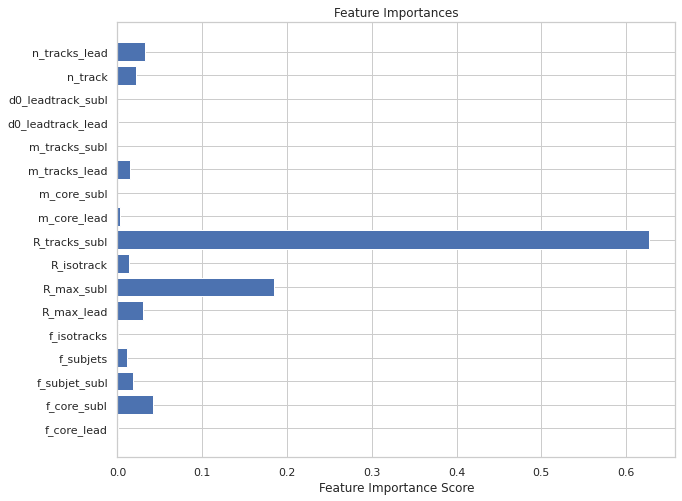

CPU times: user 18min 38s, sys: 58.3 s, total: 19min 36s
Wall time: 51min 53s
[CV] END ..learning_rate=0.05, max_depth=4, n_estimators=150; total time=  16.9s
[CV] END ..learning_rate=0.15, max_depth=2, n_estimators=100; total time=  12.9s
[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=100; total time=  12.7s
[CV] END ...learning_rate=0.3, max_depth=5, n_estimators=150; total time=  16.3s
[CV] END ..learning_rate=0.15, max_depth=3, n_estimators=100; total time=  12.6s
[CV] END ...learning_rate=0.2, max_depth=2, n_estimators=100; total time=  12.6s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=400; total time=  39.6s
[CV] END ...learning_rate=0.3, max_depth=4, n_estimators=150; total time=  16.3s
[CV] END ..learning_rate=0.15, max_depth=2, n_estimators=300; total time=  27.7s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=450; total time=  37.4s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=500; total time=  45.6s
[CV] END ..learning_rate=0.15, 

In [29]:
%%time
fpr1, tpr1, thresholds1, auc1 = BDT(df_1p1p)
fpr2, tpr2, thresholds2, auc2 = BDT(df_3p3p)
fpr3, tpr3, thresholds3, auc3 = BDT(df_1p3p)
fpr4, tpr4, thresholds4, auc4 = BDT(df)

/tmp/ipykernel_1358/4274570427.py:16: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr1, 1/fpr1, lw=1, label='1p1p (area = %0.5f)' % auc1)
/tmp/ipykernel_1358/4274570427.py:17: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2, 1/fpr2, lw=1, label='3p3p (area = %0.5f)' % auc2)
/tmp/ipykernel_1358/4274570427.py:18: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr3, 1/fpr3, lw=1, label='1p3p (area = %0.5f)' % auc3)
/tmp/ipykernel_1358/4274570427.py:19: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr4, 1/fpr4, lw=1, label='All (area = %0.5f)' % auc4)


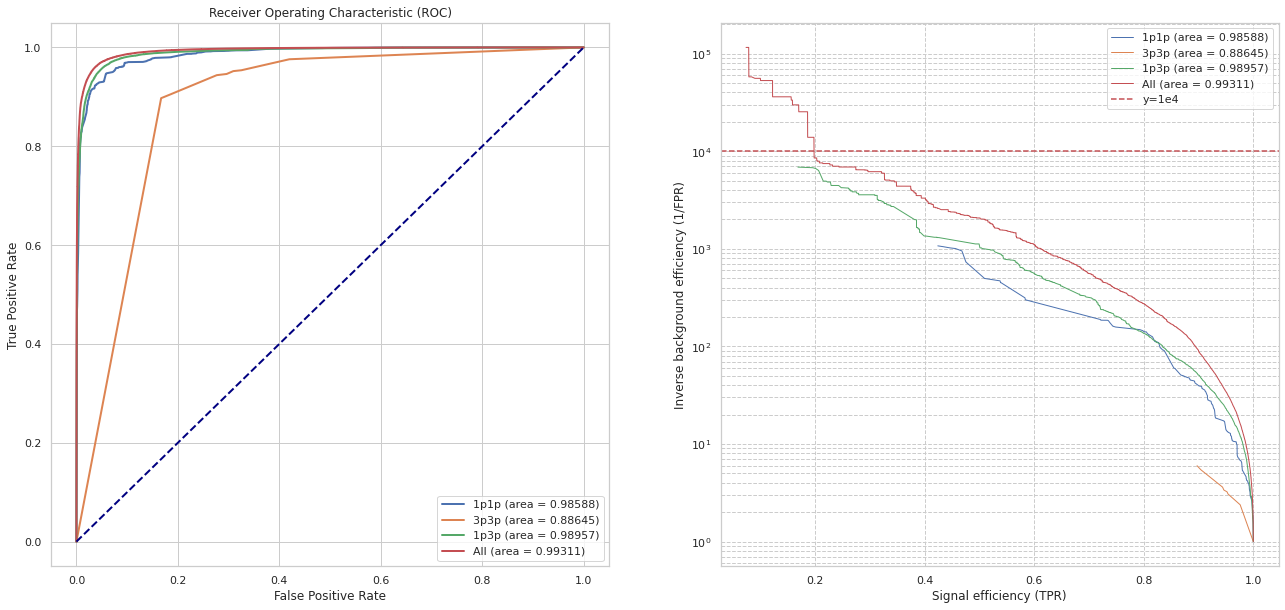

In [33]:
# Plotting ROC Curve
plt.figure(figsize=(22, 10))
plt.subplot(121)
plt.plot(fpr1, tpr1, lw=2, label='1p1p (area = %0.5f)' % auc1)
plt.plot(fpr2, tpr2, lw=2, label='3p3p (area = %0.5f)' % auc2)
plt.plot(fpr3, tpr3, lw=2, label='1p3p (area = %0.5f)' % auc3)
plt.plot(fpr4, tpr4, lw=2, label='All (area = %0.5f)' % auc4)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)

plt.subplot(122)
plt.plot(tpr1, 1/fpr1, lw=1, label='1p1p (area = %0.5f)' % auc1)
plt.plot(tpr2, 1/fpr2, lw=1, label='3p3p (area = %0.5f)' % auc2)
plt.plot(tpr3, 1/fpr3, lw=1, label='1p3p (area = %0.5f)' % auc3)
plt.plot(tpr4, 1/fpr4, lw=1, label='All (area = %0.5f)' % auc4)

plt.xlabel('Signal efficiency (TPR)')
plt.ylabel('Inverse background efficiency (1/FPR)')
plt.yscale('log')
# yticks = np.linspace(0, 10e9, 71)
# plt.yticks(yticks, labels=[str(ytick) for ytick in yticks])
plt.axhline(y=1e4, color='r', linestyle='--', label='y=1e4')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()


### Comment: 3p3p has 2 dominating variables -> bad bdt score
## All -> 1p1p, 3p3p, 1p3p

train bkg: 1743956, train signal: 3874516, test bkg: 436601, test signal: 967664


/tmp/ipykernel_1358/2796966121.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data.rename(columns=feature_mapping, inplace=True)
/tmp/ipykernel_1358/2796966121.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_data.rename(columns=feature_mapping, inplace=True)


Fitting 3 folds for each of 30 candidates, totalling 90 fits


/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.62407
[1]	validation_0-logloss:0.57422
[2]	validation_0-logloss:0.53153
[3]	validation_0-logloss:0.49477
[4]	validation_0-logloss:0.46257
[5]	validation_0-logloss:0.43448
[6]	validation_0-logloss:0.40919
[7]	validation_0-logloss:0.38751
[8]	validation_0-logloss:0.36782
[9]	validation_0-logloss:0.34978
[10]	validation_0-logloss:0.33320
[11]	validation_0-logloss:0.31889
[12]	validation_0-logloss:0.30606
[13]	validation_0-logloss:0.29397
[14]	validation_0-logloss:0.28281
[15]	validation_0-logloss:0.27349
[16]	validation_0-logloss:0.26511
[17]	validation_0-logloss:0.25624
[18]	validation_0-logloss:0.24876
[19]	validation_0-logloss:0.24163
[20]	validation_0-logloss:0.23446
[21]	validation_0-logloss:0.22860
[22]	validation_0-logloss:0.22289
[23]	validation_0-logloss:0.21724
[24]	validation_0-logloss:0.21266
[25]	validation_0-logloss:0.20762
[26]	validation_0-logloss:0.20300
[27]	validation_0-logloss:0.19823
[28]	validation_0-logloss:0.19438
[29]	validation_0-loglos

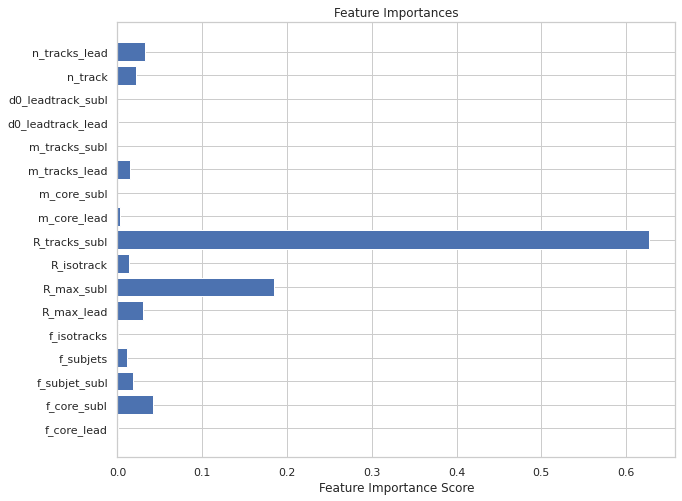

[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=100; total time=  36.6s
[CV] END ...learning_rate=0.2, max_depth=4, n_estimators=100; total time=  36.4s
[CV] END ...learning_rate=0.2, max_depth=4, n_estimators=100; total time=  34.7s
[CV] END ...learning_rate=0.2, max_depth=2, n_estimators=100; total time=  35.5s
[CV] END ...learning_rate=0.3, max_depth=5, n_estimators=300; total time= 1.1min
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=400; total time= 1.9min
[CV] END ..learning_rate=0.15, max_depth=2, n_estimators=300; total time= 1.1min
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=300; total time= 1.4min
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=500; total time= 2.2min
[CV] END ..learning_rate=0.15, max_depth=5, n_estimators=300; total time= 1.2min
[CV] END ...learning_rate=0.2, max_depth=4, n_estimators=150; total time=  46.2s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=350; total time= 1.6min
[CV] END ..learning_rate=0.1

In [34]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

training_vars = ["f_core_lead",
                "f_core_subl",
                "f_subjet_subl",
                "f_subjets",
                "f_isotracks",
                "R_max_lead",
                "R_max_subl",
                "R_isotrack",
                "R_tracks_subl",
                "m_core_lead",
                "m_core_subl",
                "m_tracks_lead",
                "m_tracks_subl",
                "d0_leadtrack_lead",
                "d0_leadtrack_subl",
                "n_track",
                "n_tracks_lead"]


# Scrambling
# Calculate the modulo of each eventID with 5
df['eventID_mod'] = df['event_id'] % 5

df['weight'] = df['event_weight'] * df['pT_weight']

log_vars = ["f_isotracks", "m_core_lead", "m_core_subl", "m_tracks_lead", "m_tracks_subl"]
abs_log_var = ["d0_leadtrack_lead", "d0_leadtrack_subl"]

train_df = df[df['eventID_mod'] < 4] # 80%
test_df = df[df['eventID_mod'] == 4] # 20%
print(f'train bkg: {len(train_df[train_df.label==0])}, train signal: {len(train_df[train_df.label==1])}, test bkg: {len(test_df[test_df.label==0])}, test signal: {len(test_df[test_df.label==1])}')

train_df = train_df.drop(columns='eventID_mod')
test_df = test_df.drop(columns='eventID_mod')

# Training & Testing sets
training_data, testing_data, training_labels, testing_labels, training_weights, testing_weights = \
train_df[training_vars], test_df[training_vars], train_df['label'], test_df['label'], train_df['weight'], test_df['weight']

#Change column names to integers if needed (for ML models that expect numerical feature names)
feature_mapping = {feature: i for i, feature in enumerate(training_data.columns)}
training_data.rename(columns=feature_mapping, inplace=True)
feature_mapping = {feature: i for i, feature in enumerate(testing_data.columns)}
testing_data.rename(columns=feature_mapping, inplace=True)

# Define the classifier
bdt = XGBClassifier(random_state=0, verbosity=1)

# Define the parameter distribution
param_dist = {
    'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.3],
    'max_depth': [2, 3, 4, 5, 6]
}

# Define the search with RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=bdt, param_distributions=param_dist, n_iter=30, scoring='accuracy', cv=3, verbose=2, random_state=0, n_jobs=-1)

# Perform the search
# Note: We don't use the testing set here; it's for final evaluation
random_search.fit(training_data, training_labels, sample_weight=training_weights)

# Best estimator found by RandomizedSearchCV
best_estimator = random_search.best_estimator_

# Manually apply early stopping using a portion of the training set as a validation set
# Note: XGBoost handles validation sets for early stopping, but we use training and testing sets as provided
eval_set = [(testing_data, testing_labels)]
best_estimator.fit(training_data, training_labels, sample_weight=training_weights, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=True)

# Predictions and final evaluation on the testing set
predictions = best_estimator.predict(testing_data)
accuracy = accuracy_score(testing_labels, predictions, sample_weight=testing_weights)

# Output the results
print("Best parameters found: ", random_search.best_params_)
print("Testing accuracy after early stopping: ", accuracy)

# Predict probabilities for the testing data
probs = best_estimator.predict_proba(testing_data)
probs = probs[:, 1]

# Feature Importance
importance = best_estimator.feature_importances_
# Re-map the feature importance scores to the original feature names
feature_importances = {training_vars[i]: score for i, score in enumerate(importance)}

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(range(len(feature_importances)), list(feature_importances.values()), align='center')
plt.yticks(range(len(feature_importances)), list(feature_importances.keys()))
plt.xlabel('Feature Importance Score')
plt.title('Feature Importances')
plt.show()

/tmp/ipykernel_1358/1945753216.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_subset.rename(columns=feature_mapping, inplace=True)
/tmp/ipykernel_1358/1945753216.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_subset.rename(columns=feature_mapping, inplace=True)
/tmp/ipykernel_1358/1945753216.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_subset.rename(columns=feature_mapping, inplace=True)
/tmp/ipykernel_1358/19457

<Figure size 720x576 with 0 Axes>

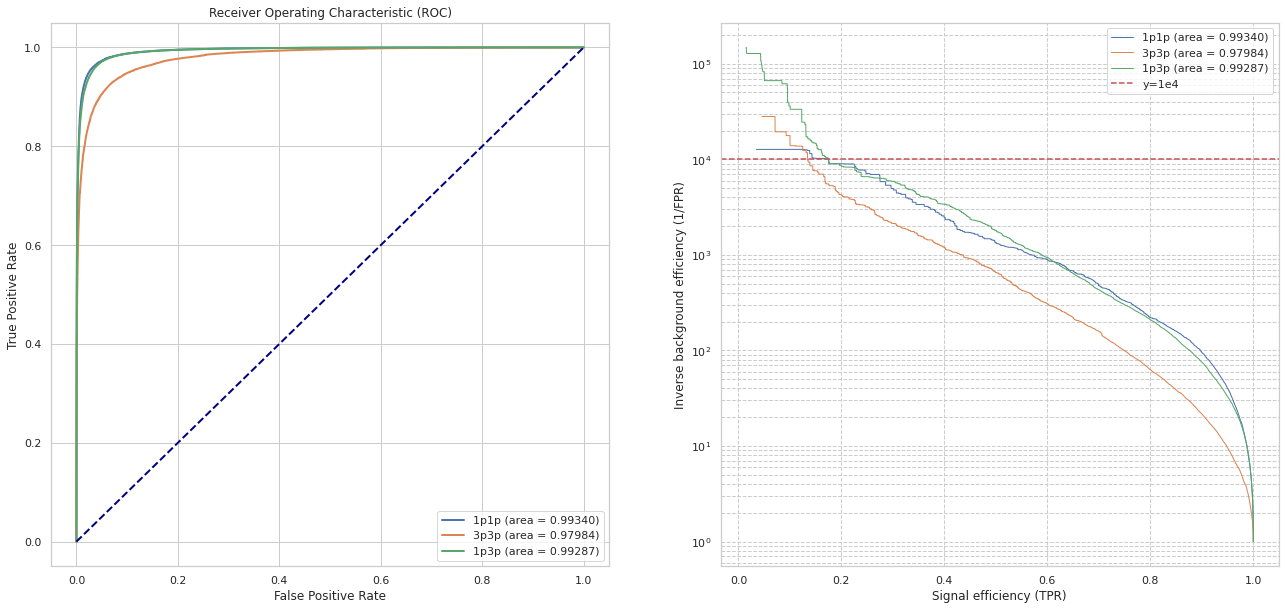

In [35]:
def evaluate_model_and_plot_roc(bdt, df_subset, training_vars, subset_label):
    # Prepare the subset's data
    X_subset = df_subset[training_vars]
    y_subset = df_subset['label']
    weights_subset = df_subset['weight']
    
        #Change column names to integers if needed (for ML models that expect numerical feature names)
    feature_mapping = {feature: i for i, feature in enumerate(X_subset.columns)}
    X_subset.rename(columns=feature_mapping, inplace=True)
    
    # Predict probabilities for the subset data
    probs_subset = bdt.predict_proba(X_subset)[:, 1]  # Assuming positive class is at index 1

    # Calculate FPR, TPR, and AUC for the subset
    fpr, tpr, thresholds = roc_curve(y_subset, probs_subset, sample_weight=weights_subset)
    auc_score = roc_auc_score(y_subset, probs_subset, sample_weight=weights_subset)
    return fpr, tpr, auc_score

# After training and optimizing your BDT, you can evaluate and plot ROC curves for the subsets
plt.figure(figsize=(10, 8))


fpr5, tpr5, auc5 = evaluate_model_and_plot_roc(best_estimator, df_1p1p, training_vars, '1p1p')
fpr6, tpr6, auc6 = evaluate_model_and_plot_roc(best_estimator, df_3p3p, training_vars, '3p3p')
fpr7, tpr7, auc7 = evaluate_model_and_plot_roc(best_estimator, df_1p3p, training_vars, '1p3p')

# Plotting ROC Curve
plt.figure(figsize=(22, 10))
plt.subplot(121)
plt.plot(fpr5, tpr5, lw=2, label='1p1p (area = %0.5f)' % auc5)
plt.plot(fpr6, tpr6, lw=2, label='3p3p (area = %0.5f)' % auc6)
plt.plot(fpr7, tpr7, lw=2, label='1p3p (area = %0.5f)' % auc7)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)

plt.subplot(122)
plt.plot(tpr5, 1/fpr5, lw=1, label='1p1p (area = %0.5f)' % auc5)
plt.plot(tpr6, 1/fpr6, lw=1, label='3p3p (area = %0.5f)' % auc6)
plt.plot(tpr7, 1/fpr7, lw=1, label='1p3p (area = %0.5f)' % auc7)

plt.xlabel('Signal efficiency (TPR)')
plt.ylabel('Inverse background efficiency (1/FPR)')
plt.yscale('log')
# yticks = np.linspace(0, 10e9, 71)
# plt.yticks(yticks, labels=[str(ytick) for ytick in yticks])
plt.axhline(y=1e4, color='r', linestyle='--', label='y=1e4')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

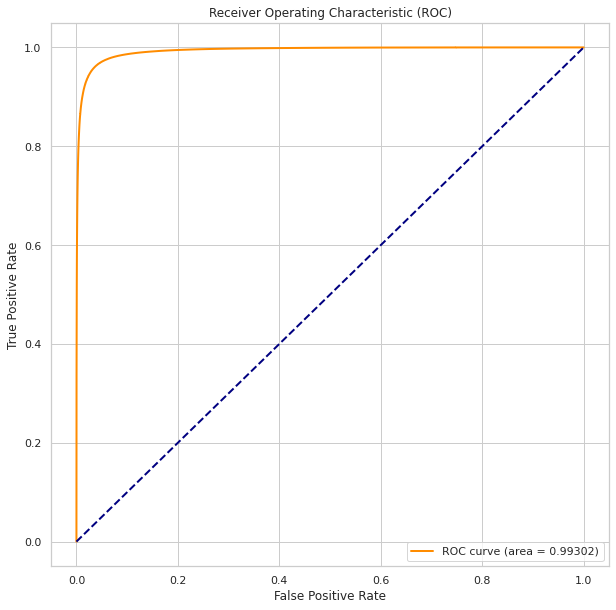

In [36]:
# Old BDT ROC

scores = df['bdt_score']
true_labels = df['label'] 

fpr, tpr, thresholds = roc_curve(true_labels, scores)

# Calculate the Area Under the Curve (AUC) for ROC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()